<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37400 - Fixed Income</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework #5- Forward Rates and the Carry Trade</center></h2>

<center>Due: Monday, Feb 5 at 6PM</center>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

# Homework 5

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# 1. Forward Rates

Use the data set `famabliss_strips_2023-12-29.xlsx`.

It gives prices on **zero coupon bonds** with maturities of 1 through 5 years.
* These are prices per \\$1 face value on bonds that only pay principal.
* Such bonds can be created from treasuries by *stripping* out their coupons.
* In essence, you can consider these prices as the discount factors $Z$, for maturity intervals 1 through 5 years.

In this problem, we focus on six dates: the month of December in 2018 through 2023.

In [4]:
date = '2023-12-29'
filepath = f'../data/famabliss_strips_{date}.xlsx'
prices = pd.read_excel(filepath, sheet_name='prices')
prices.set_index('date',inplace=True)
prices.columns = prices.columns.astype(int)
prices = prices/100
prices.head()

,1,2,3,4,5
date,,,,,
1952-06-30,0.981778,0.962531,0.942467,0.926341,0.904183
1952-07-31,0.980948,0.960315,0.939312,0.923089,0.898516
1952-08-29,0.980578,0.959750,0.937819,0.921458,0.895717
1952-09-30,0.980312,0.959098,0.937551,0.920961,0.891676
1952-10-31,0.981108,0.959745,0.937583,0.919290,0.897248


## 1.1

For each of the six dates, (Dec 2018, Dec 2019, ...), calculate the forward discount factor, $F(t,T_1,T_2)$, where $T_2 = T_1 + 1$ for $1\le T_1\le 4$.

Make a plot of the curve $F$ at each of these six dates.

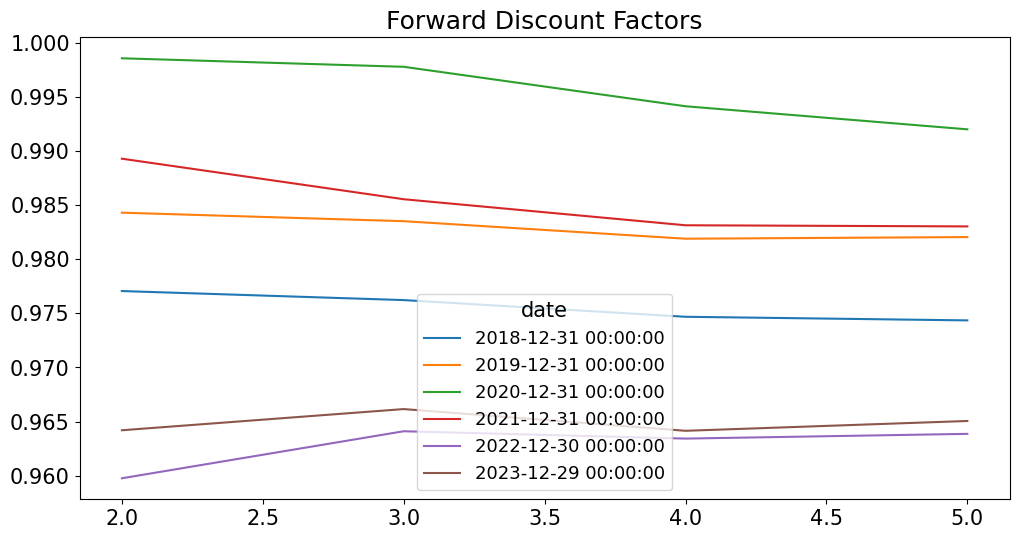

In [76]:
px = prices.iloc[-61::12]
F = px[[2,3,4,5]] / px[[1,2,3,4]].values
F.T.plot(title = 'Forward Discount Factors')
plt.show()

## 1.2



Use $F$ above to calculate the continuously compounded forward rates, $f$, at the six dates.

Make a plot of the curve, $f$, at each of these six dates.

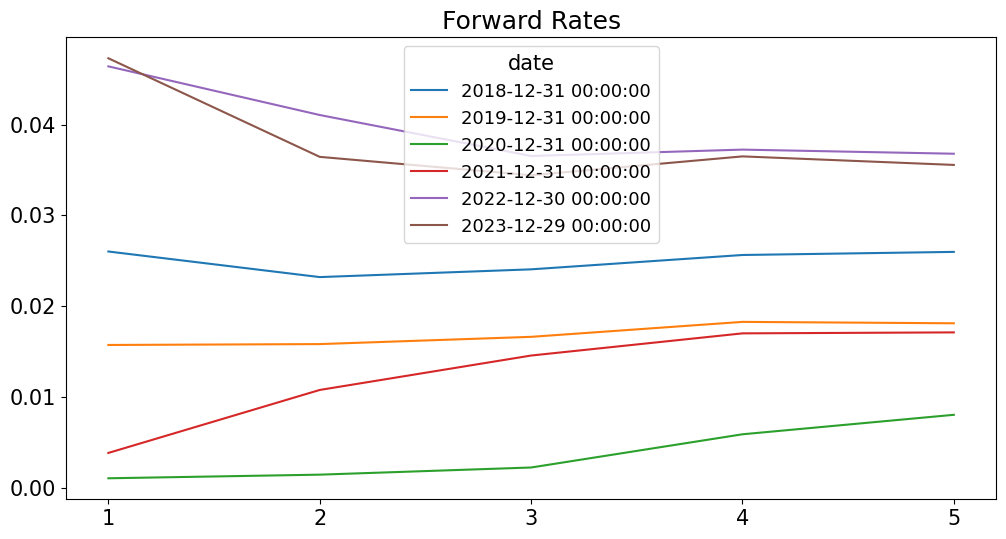

In [77]:
spots = -np.log(px)/ px.columns
f = -np.log(F)
f.insert(0,1, spots[1])
f.T.plot(title = 'Forward Rates', xticks = f.columns)
plt.show()

## 1.3

Calculate the continuously compounded spot rates, $r$, at the six dates.

Plot both the forward curve and the spot curve on the date of Dec 2018.

Recall that $f(t,t,t+1) = r(t,t+1)$.

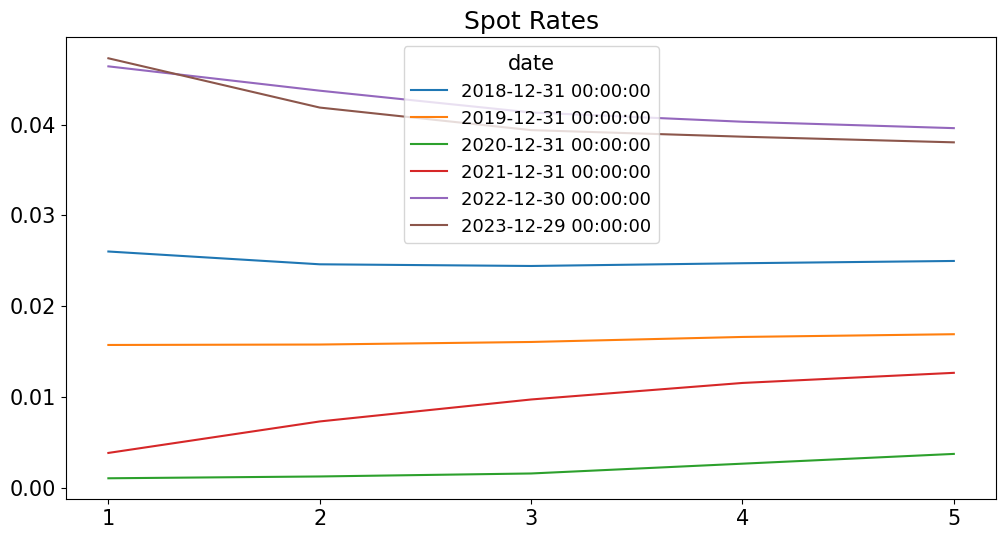

In [78]:
DATE = '2018'
spots.T.plot(title = 'Spot Rates', xticks = spots.columns)
plt.show()

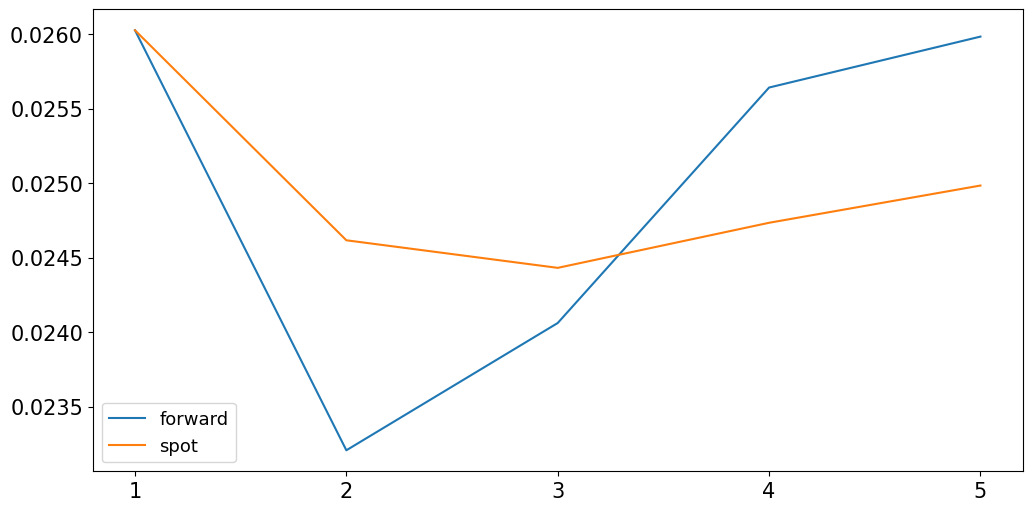

In [79]:
ax = f.loc[DATE].T.plot(xticks=f.columns)
spots.loc[DATE].T.plot(ax=ax)
ax.legend(['forward','spot'])
plt.show()

> The forward curve is below the spot curve for the first 3 years so the spot curve is downward sloping, but after that the forward curve is above the spot curve so it is upward sloping

## 1.4

Plot the forward curve on Dec 2018 against the time-series evolution of $r(t,t+1)$ for dates $t$ between Dec 2018 and Dec 2022.

How does the evolution of one-year rates between 2018-2022 compare to the forward rates of 2018?

In [80]:
temp = f.loc[DATE].T

temp.columns.name = f'{DATE}: (n-1) to n'
temp.columns = [f'forward curve']
temp['spot over time'] = spots[1].values[:-1]
temp

,forward curve,spot over time
1,0.026026,0.026026
2,0.023207,0.015729
3,0.024061,0.001042
4,0.025642,0.003834
5,0.025984,0.046425


The realized one-year spot rates over 2019-2021 are much lower than what was implied by the 2018 forward curve---with the exception of the realized spot in 2022 (at year 5) being higher than the forward rate implication.

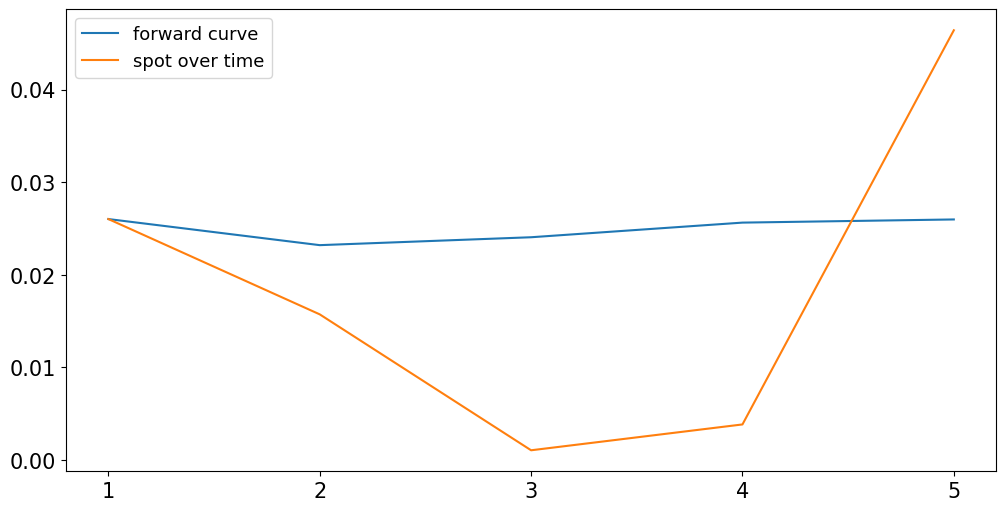

In [81]:
ax = temp.plot(xticks=temp.index)

***

# 2. Carry Trade

## 2.1

Suppose it is December 2018, and you determine to implement a carry trade with the following specification...

* Long \\$100 million (market value, not face value) of the 5-year zero-coupon bond (maturing Dec 2023.)
* Short \\$100 million (market value, not face value) of the 1-year zero-coupon bond (maturing Dec 2019.)
* Assume there is a 2% haircut on each side of the trade, so it requires \\$4 million of investor capital to initiate it.

1. Calculate the total profit and loss year-by-year.
1. Calculate the total return (Dec 2023) on the initial \\$4 million of investor capital.

#### Short position
* Each year you will roll over the short position to maintain a short \\$100 million (market value) in the 1-year bond.
* This will require injecting more cash into the trade, as the expiring short will require more than \$100 million to close out. 
* In Dec 2022, no need to open a new short position, as your long position will (at that point) be a one-year bond.

#### Alternatives
The scheme above is for simplicity. You could try more interesting ways of setting the short position...
* Open a new short position sized to whatever is needed to cover the expiring short position.
* Set the short positions to duration-hedge the long position.

In [82]:
# Parameters
HAIRCUT = .02
INIT_SIZE = 1e8
FACE = 1e6

p = px.copy()
p.insert(0,'cash',1)
p *= FACE

In [83]:
# Create empty dataframes to store values and pnl
value = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)
pnl = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)

# Initialize pnl and value at the starting date
pnl.loc[DATE] = 0
value.loc[DATE] = np.array([0,-INIT_SIZE,0,0,0,INIT_SIZE])

# Calculate positions based on value and prices
positions = value / p

# Set the end date
dt_end = p.index[-1]

# Loop through each date and calculate positions, value, and pnl
for i, dt in enumerate(p.index[1:]):
    dt_lag = p.index[i]
    
    # Shift positions to the next date
    positions.loc[dt] = positions.loc[dt_lag].shift(-1)
    positions.loc[dt,5] = 0        

    # Adjust positions if it's not the end date
    if dt != dt_end:
        positions.loc[dt,1] += -INIT_SIZE / p.loc[dt,1]
        positions.loc[dt,'cash'] += INIT_SIZE / p.loc[dt,'cash']

    # Calculate value and pnl at each date
    value.loc[dt] = positions.loc[dt] * p.loc[dt]
    pnl.loc[dt] = value.loc[dt] - value.loc[dt_lag]
    pnl.loc[dt,'cash'] = value.loc[dt,'cash']
    
# Calculate net pnl and cumulative pnl
pnl.insert(0,'net',pnl.sum(axis=1))
pnl.loc['cumulative','net'] = pnl['net'].sum()

# Replace 0 values with NaN for better visualization
positions.replace(0,np.nan,inplace=True)
value.replace(0,np.nan,inplace=True)
pnl.replace(0,np.nan,inplace=True)

# Print positions, value, and pnl
print('Positions:')
display(positions.style.format('{:,.5}',na_rep=''))
print('Value:')
display(value.style.format('${:,.2f}',na_rep=''))
print('PnL:')
display(pnl.style.format('${:,.2f}',na_rep=''))

Positions:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,-102.64,,,,113.31
2019-12-31 00:00:00,-2.6368,-101.59,,,113.31,
2020-12-31 00:00:00,-1.5853,-100.1,,113.31,,
2021-12-31 00:00:00,-0.10424,-100.38,113.31,,,
2022-12-30 00:00:00,-0.38415,8.5538,,,,
2023-12-29 00:00:00,8.5538,,,,,


Value:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,"$-100,000,000.00",,,,"$100,000,000.00"
2019-12-31 00:00:00,"$-2,636,787.00","$-100,000,000.00",,,"$106,021,315.23",
2020-12-31 00:00:00,"$-1,585,323.78","$-100,000,000.00",,"$112,773,076.00",,
2021-12-31 00:00:00,"$-104,244.84","$-100,000,000.00","$111,662,841.48",,,
2022-12-30 00:00:00,"$-384,148.40","$8,165,785.45",,,,
2023-12-29 00:00:00,"$8,553,819.87",,,,,


PnL:


,net,cash,1,2,3,4,5
date,,,,,,,
2018-12-31 00:00:00,,,,,,,
2019-12-31 00:00:00,"$3,384,528.23","$-2,636,787.00",,,,"$106,021,315.23","$-100,000,000.00"
2020-12-31 00:00:00,"$5,166,436.98","$-1,585,323.78",,,"$112,773,076.00","$-106,021,315.23",
2021-12-31 00:00:00,"$-1,214,479.36","$-104,244.84",,"$111,662,841.48","$-112,773,076.00",,
2022-12-30 00:00:00,"$-3,881,204.42","$-384,148.40","$108,165,785.45","$-111,662,841.48",,,
2023-12-29 00:00:00,"$388,034.42","$8,553,819.87","$-8,165,785.45",,,,
cumulative,"$3,843,315.85",,,,,,


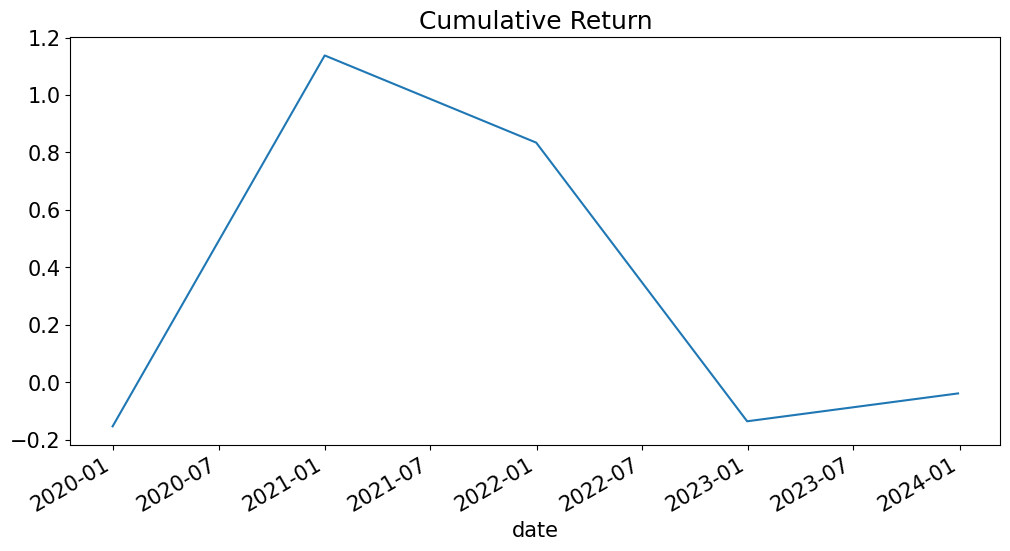

In [84]:
capital = HAIRCUT * INIT_SIZE * 2

cum_ret = pnl['net'].cumsum().drop('cumulative') / capital - 1
cum_ret.name = 'cumulative return'
cum_ret = cum_ret.iloc[1:]
cum_ret.plot(title = 'Cumulative Return')
plt.show()

## 2.2

How would this trade play out if the path of one-year spot rates equaled the forward rates observed in 2018?

The return to holding the 5-year bond would equal the return to holding the one-year bond and rolling it over five years which wouldn't be profitable

## 2.3

Given Fact 3 of the *dynamic* (conditional) tests of EH in notebook W.5., do you expect that as of Dec 2023 the long-short trade above looks more or less favorable for Dec 2023-2028 than it did for Dec 2018-2023?

In [85]:
f-spots

,1,2,3,4,5
date,,,,,
2018-12-31,0.0,-0.001410,-0.000370,0.000908,0.001000
2019-12-31,0.0,0.000048,0.000564,0.001659,0.001204
2020-12-31,0.0,0.000200,0.000658,0.003238,0.004308
2021-12-31,0.0,0.003469,0.004841,0.005463,0.004456
2022-12-30,0.0,-0.002681,-0.004797,-0.003071,-0.002819
2023-12-29,0.0,-0.005430,-0.004972,-0.002170,-0.002487


This is a question as to whether the forward-spot spread is bigger in 2018 or 2023. In W.5., we learned (in Dynamic Fact 3) that in times of higher forward-spot spreads, the expected excess return and realized yields are larger.

The table below shows that the forward-spot spread on 5-year bonds was 1bps in 2018 and negative 2.5bps in 2023. Thus, we expect that the return to this trade (long 5-year bond, short 1-year bond) will be substantially worse in 2023-2028.

***

# Alternatives 

* Open a new short position sized to whatever is needed to cover the expiring short position.

In [88]:
value = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)
pnl = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)
pnl.loc[DATE] = 0
value.loc[DATE] = np.array([0, -INIT_SIZE, 0, 0, 0, INIT_SIZE])

# Calculate positions based on value and prices
positions = value / p

# Set the end date
dt_end = p.index[-1]

# Loop through each date and calculate positions, value, and PnL
for i, dt in enumerate(p.index[1:]):
    dt_lag = p.index[i]
    
    # Shift positions to the next date
    positions.loc[dt] = positions.loc[dt_lag].shift(-1)
    positions.loc[dt, 5] = 0  # Reset long position for the new period

    if dt != dt_end:
        # Calculate the value needed to cover the expiring short position
        # This is the value of the short position at the current bond price
        cover_short_value = -positions.loc[dt, 1] * p.loc[dt, 1]
        
        # Calculate the new size of the short position based on current prices
        positions.loc[dt, 1] = -cover_short_value / p.loc[dt, 1]
        
        # Adjust cash to reflect the cash movement in covering the short
        positions.loc[dt, 'cash'] += (cover_short_value - INIT_SIZE) / p.loc[dt, 'cash']

    # Calculate value and pnl at each date
    value.loc[dt] = positions.loc[dt] * p.loc[dt]
    pnl.loc[dt] = value.loc[dt] - value.loc[dt_lag]
    pnl.loc[dt, 'cash'] = value.loc[dt, 'cash']

# Calculate net pnl and cumulative pnl
pnl.insert(0, 'net', pnl.sum(axis=1))
pnl.loc['cumulative', 'net'] = pnl['net'].sum()

# Replace 0 values with NaN for better visualization
positions.replace(0, np.nan, inplace=True)
value.replace(0, np.nan, inplace=True)
pnl.replace(0, np.nan, inplace=True)

# Print positions, value, and pnl
print('Positions:')
display(positions.style.format('{:,.5}',na_rep=''))
print('Value:')
display(value.style.format('${:,.2f}',na_rep=''))
print('PnL:')
display(pnl.style.format('${:,.2f}',na_rep=''))

Positions:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,-102.64,,,,113.31
2019-12-31 00:00:00,-202.64,,,,113.31,
2020-12-31 00:00:00,-100.0,,,113.31,,
2021-12-31 00:00:00,-100.0,,113.31,,,
2022-12-30 00:00:00,-208.17,113.31,,,,
2023-12-29 00:00:00,113.31,,,,,


Value:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,"$-100,000,000.00",,,,"$100,000,000.00"
2019-12-31 00:00:00,"$-202,636,787.00",,,,"$106,021,315.23",
2020-12-31 00:00:00,"$-100,000,000.00",,,"$112,773,076.00",,
2021-12-31 00:00:00,"$-100,000,000.00",,"$111,662,841.48",,,
2022-12-30 00:00:00,"$-208,165,785.45","$108,165,785.45",,,,
2023-12-29 00:00:00,"$113,305,774.53",,,,,


PnL:


,net,cash,1,2,3,4,5
date,,,,,,,
2018-12-31 00:00:00,,,,,,,
2019-12-31 00:00:00,"$-96,615,471.77","$-202,636,787.00","$100,000,000.00",,,"$106,021,315.23","$-100,000,000.00"
2020-12-31 00:00:00,"$-93,248,239.23","$-100,000,000.00",,,"$112,773,076.00","$-106,021,315.23",
2021-12-31 00:00:00,"$-101,110,234.52","$-100,000,000.00",,"$111,662,841.48","$-112,773,076.00",,
2022-12-30 00:00:00,"$-211,662,841.48","$-208,165,785.45","$108,165,785.45","$-111,662,841.48",,,
2023-12-29 00:00:00,"$5,139,989.08","$113,305,774.53","$-108,165,785.45",,,,
cumulative,"$-497,496,797.92",,,,,,


* Set the short positions to duration-hedge the long position.

In [91]:
value = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)
pnl = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)
pnl.loc[DATE] = 0
value.loc[DATE] = np.array([0, -INIT_SIZE, 0, 0, 0, INIT_SIZE])

# Calculate positions based on value and prices
positions = value / p

# Set the end date
dt_end = p.index[-1]

# Function to calculate duration; here it's simplified as years to maturity for zero-coupon bonds
def calculate_duration(time_to_maturity):
    return time_to_maturity  # Simplification for zero-coupon bonds

# Loop through each date and calculate positions, value, and PnL
for i, dt in enumerate(p.index[1:]):
    dt_lag = p.index[i]
    
    # Shift positions to the next date
    positions.loc[dt] = positions.loc[dt_lag].shift(-1)
    positions.loc[dt, 5] = 0  # Reset long position for the new period

    if dt != dt_end:
        # Calculate durations for long and short positions
        long_duration = calculate_duration(5 - i/12)  # Assuming 5 years at start, adjusted for each month
        short_duration = 1  # Since it's always a 1-year bond for the short position

        # Calculate the duration-adjusted size of the short position
        duration_adjusted_size = INIT_SIZE * (long_duration / short_duration)
        
        # Adjust the short position to match the duration-weighted value of the long position
        positions.loc[dt, 1] = -duration_adjusted_size / p.loc[dt, 1]
        
        # Adjust cash to reflect the movement in covering the short
        positions.loc[dt, 'cash'] += (duration_adjusted_size - INIT_SIZE) / p.loc[dt, 'cash']

    # Calculate value and pnl at each date
    value.loc[dt] = positions.loc[dt] * p.loc[dt]
    pnl.loc[dt] = value.loc[dt] - value.loc[dt_lag]
    pnl.loc[dt, 'cash'] = value.loc[dt, 'cash']

# Calculate net pnl and cumulative pnl
pnl.insert(0, 'net', pnl.sum(axis=1))
pnl.loc['cumulative', 'net'] = pnl['net'].sum()

# Replace 0 values with NaN for better visualization
positions.replace(0, np.nan, inplace=True)
value.replace(0, np.nan, inplace=True)
pnl.replace(0, np.nan, inplace=True)
# Print positions, value, and pnl
print('Positions:')
display(positions.style.format('{:,.5}',na_rep=''))
print('Value:')
display(value.style.format('${:,.2f}',na_rep=''))
print('PnL:')
display(pnl.style.format('${:,.2f}',na_rep=''))

Positions:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,-102.64,,,,113.31
2019-12-31 00:00:00,297.36,-507.93,,,113.31,
2020-12-31 00:00:00,-116.26,-492.18,,113.31,,
2021-12-31 00:00:00,-108.85,-485.19,113.31,,,
2022-12-30 00:00:00,-110.19,-497.57,,,,
2023-12-29 00:00:00,-497.57,,,,,


Value:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,"$-100,000,000.00",,,,"$100,000,000.00"
2019-12-31 00:00:00,"$297,363,213.00","$-500,000,000.00",,,"$106,021,315.23",
2020-12-31 00:00:00,"$-116,259,952.25","$-491,666,666.67",,"$112,773,076.00",,
2021-12-31 00:00:00,"$-108,845,870.45","$-483,333,333.33","$111,662,841.48",,,
2022-12-30 00:00:00,"$-110,190,050.59","$-475,000,000.00",,,,
2023-12-29 00:00:00,"$-497,571,784.62",,,,,


PnL:


,net,cash,1,2,3,4,5
date,,,,,,,
2018-12-31 00:00:00,,,,,,,
2019-12-31 00:00:00,"$-96,615,471.77","$297,363,213.00","$-400,000,000.00",,,"$106,021,315.23","$-100,000,000.00"
2020-12-31 00:00:00,"$-101,174,858.15","$-116,259,952.25","$8,333,333.33",,"$112,773,076.00","$-106,021,315.23",
2021-12-31 00:00:00,"$-101,622,771.64","$-108,845,870.45","$8,333,333.33","$111,662,841.48","$-112,773,076.00",,
2022-12-30 00:00:00,"$-213,519,558.74","$-110,190,050.59","$8,333,333.33","$-111,662,841.48",,,
2023-12-29 00:00:00,"$-22,571,784.62","$-497,571,784.62","$475,000,000.00",,,,
cumulative,"$-535,504,444.91",,,,,,
